DATASET

In [1]:
from google.cloud import storage
storage_client = storage.Client()
bucket = storage_client.get_bucket("geoguessr-imgs")

coords = []
countries = set()
blobs = bucket.list_blobs(prefix="streetviews/")
for blob in blobs:
    coord = blob.name.split('/')[-1].split(',')
    lat = coord[0]
    long = coord[1][:-4]
    coords.append([float(lat), float(long)])
    countries.add(blob.name.split('/')[1])

countries = list(countries)
countries.sort()
print(f"Total number of streetview images: {len(coords)}")

Total number of streetview images: 15229


In [2]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame(coords, columns=['lat', 'long'])

fig = px.scatter_mapbox(df, 
                        lat="lat", 
                        lon="long", 
                        zoom=1, 
                        height=500,
                        width=1000)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

MODEL

In [ ]:
from huggingface_hub import from_pretrained_keras

coordinate_model = from_pretrained_keras("rohanmyer/latlongpredictor", compile=False)
country_model = from_pretrained_keras("rohanmyer/countryclassifier", compile=False)

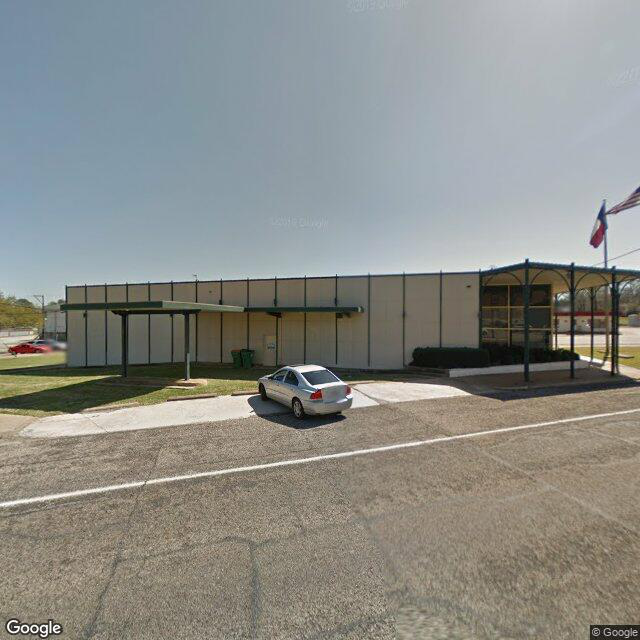

In [4]:
from google_scraping import StreetViewer
import requests
from faker import Faker

fake = Faker()
# true_coord = fake.location_on_land() # (latitude, longitude, place name, two-letter country code, timezone)
true_coord = fake.local_latlng(country_code='US')

true_coord = [float(true_coord[0]), float(true_coord[1])]

pic_params = dict(key="API_KEY",
                  location=f"{true_coord[0]},{true_coord[1]}",
                  size="640x640")

pic_response = requests.get('https://maps.googleapis.com/maps/api/streetview?',
                            params=pic_params)

import io
from PIL import Image

stream = io.BytesIO(pic_response.content)
streetview = Image.open(stream)
streetview


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

image = np.array(streetview)
image = tf.image.resize(image, [256, 256])
image = preprocess_input(tf.expand_dims(image, axis=0))
pred_coord = coordinate_model(image).numpy()[0]
pred_country = country_model(image).numpy()[0].argmax()
pred_country = countries[pred_country]

print(f"Predicted Country: {pred_country}")
print(f"Predicted Coordinate: {pred_coord}")

2023-05-02 16:44:03.345265: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Predicted Country: US
Predicted Coordinate: [30.827068  5.851484]


In [11]:
import pycountry

true = true_coord + ['True']
pred = list(pred_coord) + ['Predicted']

df = pd.DataFrame([true, pred], columns=['lat', 'long', ' '])
df.head()

fig = px.choropleth_mapbox(
    locations=[pycountry.countries.get(alpha_2=pred_country).alpha_3],
    color=[1],
    geojson="https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json",
    color_continuous_scale=px.colors.sequential.Mint,
    zoom=1,
)
scatter_fig = px.scatter_mapbox(df, 
                        lat="lat", 
                        lon="long", 
                        color_continuous_scale=px.colors.sequential.Brwnyl,
                        zoom=1, 
                        color=" ",
                        height=400,
                        width=1000)

fig.add_trace(scatter_fig.data[0])
fig.add_trace(scatter_fig.data[1])

fig.update_layout(showlegend=False)
fig.update(layout_coloraxis_showscale=False)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

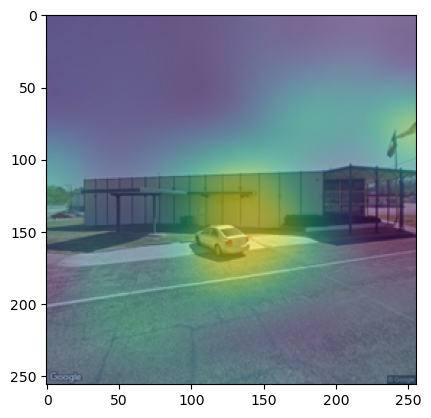

In [7]:
from heatmap import generate_heatmap

import matplotlib.pyplot as plt
from scipy.ndimage import zoom

gradcam = generate_heatmap(coordinate_model, image)
scale = 256 / gradcam.shape[0]
plt.imshow(streetview.resize((256, 256)))
plt.imshow(zoom(gradcam, zoom=(scale, scale)), alpha=0.5)